Import Packages

In [ ]:
! pip install geopandas

In [ ]:
! pip install contextily

In [ ]:
#import necessary packages
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#to graph with geopandas, you also need to install descartes
import geopandas as gpd
from geopandas import GeoDataFrame
import descartes
from shapely.geometry import Point, Polygon
from functools import partial
import pyproj
from pyproj import Transformer
from pyproj import CRS
from shapely.ops import transform
import missingno as msno
from sklearn.preprocessing import OrdinalEncoder
#to make nice looking legends
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import contextily as ctx 
import os 
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [ ]:
! pip install plotly-geo

In [ ]:
from tabulate import tabulate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load Data In this dataset, we use census tracts. Each county is made up of several tracts. Census tracts represent the smallest territorial entity for which population data are available in many countries. In the U.S., census tracts are subdivided into block groups and census blocks.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DATA 606 Capstone Project/Datasets and Information/CSVs/Dem Data.csv')

In [ ]:
print(tabulate(df, headers='keys', tablefmt='psql'))

+------+---------------+-------------+---------------------+------------+-------+---------+------------+---------+---------+----------+---------+-----------+-----------+----------+-------------+----------------+-------------------+-----------+----------------+----------------+-----------+----------+----------------+--------------+---------+-----------+-----------+--------+---------------+--------------+---------------+------------+---------------+--------------+----------------+--------------+----------------+
|      |   CensusTract | State       | County              |   TotalPop |   Men |   Women |   Hispanic |   White |   Black |   Native |   Asian |   Pacific |   Citizen |   Income |   IncomeErr |   IncomePerCap |   IncomePerCapErr |   Poverty |   ChildPoverty |   Professional |   Service |   Office |   Construction |   Production |   Drive |   Carpool |   Transit |   Walk |   OtherTransp |   WorkAtHome |   MeanCommute |   Employed |   PrivateWork |   PublicWork |   SelfEmployed | 

Initial anaysis of the dataset and data cleaning 

In [ ]:
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df.describe()

CensusTract      TotalPop           Men         Women     Hispanic  \
count  4.530000e+03   4530.000000   4530.000000   4530.000000  4530.000000   
mean   2.149516e+10   4664.966446   2284.766446   2380.200000    14.086623   
std    1.508190e+10   2132.434447   1059.855702   1111.926785    17.066490   
min    4.007000e+09    366.000000    214.000000    102.000000     0.000000   
25%    9.003503e+09   3207.250000   1550.250000   1624.000000     3.200000   
50%    2.400541e+10   4371.500000   2122.500000   2223.000000     7.450000   
75%    2.705302e+10   5754.000000   2815.000000   2950.000000    17.400000   
max    5.168592e+10  23426.000000  12353.000000  11073.000000    95.700000   

             White        Black       Native        Asian      Pacific  \
count  4530.000000  4530.000000  4530.000000  4530.000000  4530.000000   
mean     59.163400    17.344680     0.639691     6.073002     0.073488   
std      27.486407    23.552276     3.452053     7.466719     0.397760   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      39.325000     2.600000     0.000000     1.100000     0.000000   
50%      65.600000     7.700000     0.000000     3.400000     0.000000   
75%      82.000000    20.800000     0.500000     8.100000     0.000000   
max      99.800000   100.000000    96.100000    61.700000    12.900000   

            Citizen         Income     IncomeErr   IncomePerCap  \
count   4530.000000    4530.000000   4530.000000    4530.000000   
mean    3191.339735   73801.348565  10854.069536   34814.473731   
std     1435.222100   36628.827768   6420.040195   16890.927615   
min      148.000000    7422.000000   1106.000000    3240.000000   
25%     2199.000000   46875.750000   6393.250000   22862.500000   
50%     2993.000000   67500.000000   9445.000000   32106.000000   
75%     3933.000000   94331.500000  13683.750000   43218.500000   
max    15001.000000  247344.000000  69819.000000  132436.000000   

       IncomePerCapErr      Poverty  ChildPoverty  Professional      Service  \
count      4530.000000  4530.000000   4530.000000   4530.000000  4530.000000   
mean       4501.711921    13.411832     17.590022     42.227572    17.107263   
std        2748.571236    12.455703     18.589486     16.465527     7.845136   
min         297.000000     0.000000      0.000000      0.500000     0.000000   
25%        2756.500000     4.500000      3.300000     30.000000    11.500000   
50%        3761.000000     8.900000     10.700000     41.500000    15.900000   
75%        5369.000000    18.300000     26.500000     54.100000    21.600000   
max       31437.000000    82.500000    100.000000     85.800000    56.800000   

            Office  Construction   Production        Drive      Carpool  \
count  4530.000000   4530.000000  4530.000000  4530.000000  4530.000000   
mean     23.759227      7.397881     9.509249    74.926358     9.798521   
std       6.036468      5.339080     6.208808    11.429837     5.306185   
min       4.600000      0.000000     0.000000    11.700000     0.000000   
25%      19.800000      3.400000     4.800000    70.500000     6.200000   
50%      23.600000      6.300000     8.300000    77.800000     8.800000   
75%      27.700000     10.100000    13.100000    82.600000    12.400000   
max      57.600000     41.200000    45.100000    98.500000    47.400000   

           Transit         Walk  OtherTransp   WorkAtHome  MeanCommute  \
count  4530.000000  4530.000000  4530.000000  4530.000000  4530.000000   
mean      6.004349     2.279183     1.814525     5.175717    28.442075   
std       8.160203     4.222517     2.106418     3.683263     6.188628   
min       0.000000     0.000000     0.000000     0.000000     9.300000   
25%       0.900000     0.300000     0.500000     2.500000    23.800000   
50%       2.900000     1.100000     1.200000     4.500000    27.900000   
75%       7.600000     2.500000     2.500000     7.000000    32.500000   
max      65.300000    66.600000    24.000000 

In [ ]:
df.shape

(4530, 37)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4530 entries, 0 to 4529
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CensusTract      4530 non-null   int64  
 1   State            4530 non-null   object 
 2   County           4530 non-null   object 
 3   TotalPop         4530 non-null   int64  
 4   Men              4530 non-null   int64  
 5   Women            4530 non-null   int64  
 6   Hispanic         4530 non-null   float64
 7   White            4530 non-null   float64
 8   Black            4530 non-null   float64
 9   Native           4530 non-null   float64
 10  Asian            4530 non-null   float64
 11  Pacific          4530 non-null   float64
 12  Citizen          4530 non-null   int64  
 13  Income           4530 non-null   float64
 14  IncomeErr        4530 non-null   float64
 15  IncomePerCap     4530 non-null   float64
 16  IncomePerCapErr  4530 non-null   float64
 17  Poverty       

In [ ]:
df.describe(percentiles=[.25,.5,.75,.90,.95,.99])

CensusTract      TotalPop           Men         Women     Hispanic  \
count  4.530000e+03   4530.000000   4530.000000   4530.000000  4530.000000   
mean   2.149516e+10   4664.966446   2284.766446   2380.200000    14.086623   
std    1.508190e+10   2132.434447   1059.855702   1111.926785    17.066490   
min    4.007000e+09    366.000000    214.000000    102.000000     0.000000   
25%    9.003503e+09   3207.250000   1550.250000   1624.000000     3.200000   
50%    2.400541e+10   4371.500000   2122.500000   2223.000000     7.450000   
75%    2.705302e+10   5754.000000   2815.000000   2950.000000    17.400000   
90%    5.105947e+10   7250.000000   3584.100000   3691.200000    36.900000   
95%    5.115390e+10   8368.650000   4136.550000   4297.550000    53.610000   
99%    5.151020e+10  11785.570000   5764.080000   6051.750000    79.700000   
max    5.168592e+10  23426.000000  12353.000000  11073.000000    95.700000   

             White        Black       Native        Asian      Pacific  \
count  4530.000000  4530.000000  4530.000000  4530.000000  4530.000000   
mean     59.163400    17.344680     0.639691     6.073002     0.073488   
std      27.486407    23.552276     3.452053     7.466719     0.397760   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      39.325000     2.600000     0.000000     1.100000     0.000000   
50%      65.600000     7.700000     0.000000     3.400000     0.000000   
75%      82.000000    20.800000     0.500000     8.100000     0.000000   
90%      90.900000    51.900000     1.400000    15.400000     0.100000   
95%      93.800000    81.000000     2.600000    21.555000     0.400000   
99%      97.200000    96.400000     6.500000    34.713000     1.500000   
max      99.800000   100.000000    96.100000    61.700000    12.900000   

            Citizen         Income     IncomeErr   IncomePerCap  \
count   4530.000000    4530.000000   4530.000000    4530.000000   
mean    3191.339735   73801.348565  10854.069536   34814.473731   
std     1435.222100   36628.827768   6420.040195   16890.927615   
min      148.000000    7422.000000   1106.000000    3240.000000   
25%     2199.000000   46875.750000   6393.250000   22862.500000   
50%     2993.000000   67500.000000   9445.000000   32106.000000   
75%     3933.000000   94331.500000  13683.750000   43218.500000   
90%     4909.300000  122446.900000  18760.300000   56383.500000   
95%     5650.850000  143557.750000  22411.100000   67181.150000   
99%     7780.970000  190541.610000  32180.850000   91621.820000   
max    15001.000000  247344.000000  69819.000000  132436.000000   

       IncomePerCapErr      Poverty  ChildPoverty  Professional      Service  \
count      4530.000000  4530.000000   4530.000000   4530.000000  4530.000000   
mean       4501.711921    13.411832     17.590022     42.227572    17.107263   
std        2748.571236    12.455703     18.589486     16.465527     7.845136   
min         297.000000     0.000000      0.000000      0.500000     0.000000   
25%        2756.500000     4.500000      3.300000     30.000000    11.500000   
50%        3761.000000     8.900000     10.700000     41.500000    15.900000   
75%        5369.000000    18.300000     26.500000     54.100000    21.600000   
90%        7664.400000    31.500000     46.700000     65.000000    27.700000   
95%        9831.100000    40.300000     56.700000     70.600000    31.600000   
99%       15050.950000    54.113000     74.226000     78.171000    40.700000   
max       31437.000000    82.500000    100.000000     85.800000    56.800000   

            Office  Construction   Production        Drive      Carpool  \
count  4530.000000   4530.000000  4530.000000  4530.000000  4530.000000   
mean     23.759227      7.397881     9.509249    74.926358     9.798521   
std       6.036468      5.339080     6.208808    11.429837     5.306185   
min       4.600000      0.000000     0.000000    11.700000     0.000000   
25%      19.800000      3.400000     4.80

Encoding the Nominal value columns ('State' and 'County') to convert them t numerical values using OrdinalEncoder

In [ ]:
ord_enc = OrdinalEncoder()
df["State_Code"] = ord_enc.fit_transform(df[["State"]])
df["County_Code"] = ord_enc.fit_transform(df[["County"]])
df.head()

CensusTract    State County  TotalPop   Men  Women  Hispanic  White  Black  \
0   4007000100  Arizona   Gila      1608   865    743       4.9   93.3    0.0   
1   4007000200  Arizona   Gila      2112  1051   1061       7.9   91.8    0.0   
2   4007000301  Arizona   Gila      6228  2719   3509      11.7   85.0    0.1   
3   4007000302  Arizona   Gila      2746  1298   1448       6.1   91.7    0.0   
4   4007000400  Arizona   Gila      3922  1905   2017      10.8   84.4    1.5   

   Native  Asian  Pacific  Citizen   Income  IncomeErr  IncomePerCap  \
0     1.1    0.7      0.0     1543  52336.0    19663.0       32179.0   
1     0.0    0.0      0.0     1610  42727.0     9881.0       27730.0   
2     2.3    0.0      0.0     5117  44781.0     6047.0       22317.0   
3     0.5    0.0      0.0     2311  40931.0     2759.0       22150.0   
4     0.5    1.2      0.0     3302  45283.0     4492.0       30122.0   

   IncomePerCapErr  Poverty  ChildPoverty  Professional  Service  Office  \
0           5105.0      7.8           0.0          32.3     12.2    45.7   
1           7654.0     18.4          32.8          32.1     22.7    26.5   
2           2457.0     17.5          26.5          37.6     23.0    21.5   
3           2422.0     14.9          15.9          24.7     25.3    32.9   
4           3884.0      9.7           0.0          42.1     20.2    11.5   

   Construction  Production  Drive  Carpool  Transit  Walk  OtherTransp  \
0           0.0         9.8   87.0      1.8      0.0   5.9          0.0   
1          13.0         5.7   72.6      3.5      0.0   3.2          3.6   
2           9.3         8.6   84.7      6.8      0.0   0.0          0.0   
3          13.8         3.4   88.1      4.2      0.0   0.0          4.1   
4          18.8         7.5   80.2      7.9      0.0   0.9          0.8   

   WorkAtHome  MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0         5.3         21.6       508         77.6        18.5           3.9   
1        17.1         24.8       714         74.1        19.3           6.6   
2         8.5         26.1      1887         67.9        26.7           5.5   
3         3.5         17.3      1148         76.8        17.0           6.2   
4        10.1         34.2      1593         81.2        14.4           4.4   

   FamilyWork  Unemployment  State_Code  County_Code  
0         0.0          22.6         0.0         27.0  
1         0.0          11.0         0.0         27.0  
2         0.0           9.1         0.0         27.0  
3         0.0           4.7         0.0         27.0  
4         0.0           5.0         0.0         27.0

Here, we find which counties have the highest and lowest incomes. 

In [ ]:
#Top and bottom five tracts based on Income  
print ("Here are the top and bottom five tracts based on Income: ")
df[["State","County","CensusTract","Income"]].sort_values(by = "Income", ascending = False)

Here are the top and bottom five tracts based on Income: 


State          County  CensusTract    Income
4088  Virginia         Fairfax  51059480100  247344.0
2648  Maryland      Montgomery  24031700608  245870.0
2833  Maryland      Montgomery  24031706009  245169.0
4089  Virginia         Fairfax  51059480201  237269.0
2832  Maryland      Montgomery  24031706008  236576.0
...        ...             ...          ...       ...
394    Arizona        Maricopa   4013113900   11207.0
1876   Georgia          Fulton  13121011800   10000.0
2967  Maryland  Baltimore city  24510170200    9861.0
467    Arizona        Maricopa   4013117300    9623.0
1299   Georgia          Clarke  13059000100    7422.0

[4530 rows x 4 columns]

In [ ]:
#Top and bottom five tracts based on Drive  
print ("Here are the top and bottom five tracts based on Car Access: ")
df[["State","County","CensusTract","Drive"]].sort_values(by = "Drive", ascending = False)

Here are the top and bottom five tracts based on Car Access: 


State          County  CensusTract  Drive
2028      Georgia      Montgomery  13209950100   98.5
4208     Virginia           Henry  51089010601   97.1
3271    Minnesota          Dakota  27037061005   96.2
2407     Maryland         Carroll  24013507703   95.0
4283     Virginia       Middlesex  51119950900   94.4
...           ...             ...          ...    ...
1710      Georgia          Fulton  13121003800   17.3
2943     Maryland  Baltimore city  24510150100   15.4
1250  Connecticut         Tolland   9013881200   15.3
2898     Maryland  Baltimore city  24510070400   13.2
2082     Maryland    Anne Arundel  24003706700   11.7

[4530 rows x 4 columns]

In [ ]:
#Top and bottom five tracts based on Poverty  
print ("Here are the top and bottom five tracts based on Poverty: ")
df[["State","County","CensusTract","Poverty"]].sort_values(by = "Poverty", ascending = False)

Here are the top and bottom five tracts based on Poverty: 


State          County  CensusTract  Poverty
1299    Georgia          Clarke  13059000100     82.5
1322    Georgia          Clarke  13059150400     80.0
3531  Minnesota        Hennepin  27053103900     74.2
3536  Minnesota        Hennepin  27053104900     73.6
467     Arizona        Maricopa   4013117300     73.3
...         ...             ...          ...      ...
2604   Maryland          Howard  24027605504      0.0
461     Arizona        Maricopa   4013116733      0.0
4327   Virginia  Prince William  51153901010      0.0
2484   Maryland       Frederick  24021751903      0.0
2796   Maryland      Montgomery  24031703602      0.0

[4530 rows x 4 columns]

In [ ]:
#Top and bottom five tracts based on Drive  
print ("Here are the top and bottom five tracts based on % Black: ")
df[["State","County","CensusTract","Income", "Black"]].sort_values(by = "Black" and "Income", ascending = False)

Here are the top and bottom five tracts based on % Black: 


State          County  CensusTract    Income  Black
4088  Virginia         Fairfax  51059480100  247344.0    2.5
2648  Maryland      Montgomery  24031700608  245870.0    1.5
2833  Maryland      Montgomery  24031706009  245169.0    2.8
4089  Virginia         Fairfax  51059480201  237269.0    3.6
2832  Maryland      Montgomery  24031706008  236576.0    0.3
...        ...             ...          ...       ...    ...
394    Arizona        Maricopa   4013113900   11207.0    8.2
1876   Georgia          Fulton  13121011800   10000.0   70.7
2967  Maryland  Baltimore city  24510170200    9861.0   94.0
467    Arizona        Maricopa   4013117300    9623.0    2.4
1299   Georgia          Clarke  13059000100    7422.0    5.3

[4530 rows x 5 columns]

In [ ]:
df = df.dropna()
df.shape

(4530, 39)

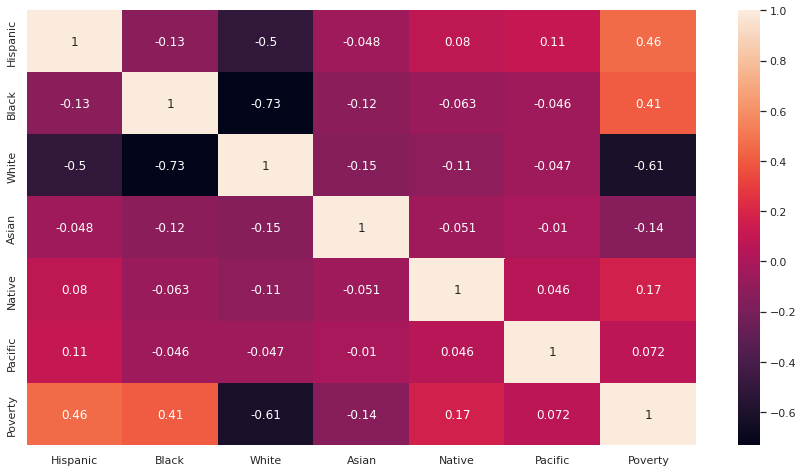

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
f = ( df.loc[:, ['Hispanic', 'Black', 'White', 'Asian', 'Native','Pacific','Poverty']]).corr()

sns.heatmap(f, annot=True)

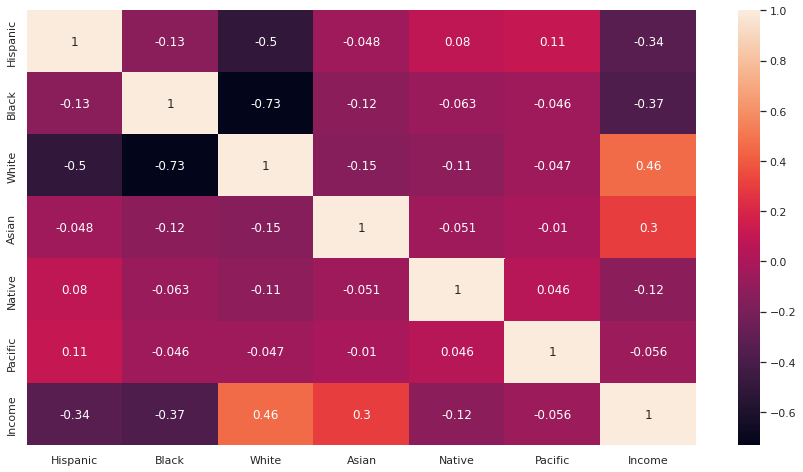

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
f = ( df.loc[:, ['Hispanic', 'Black', 'White', 'Asian', 'Native','Pacific','Income']]).corr()

sns.heatmap(f, annot=True)

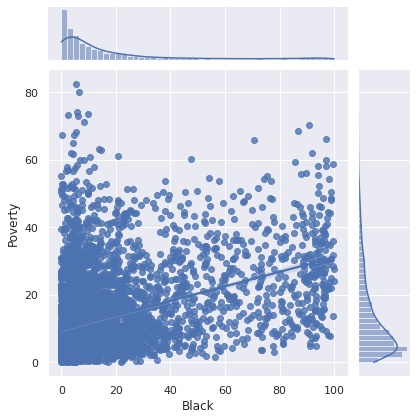

In [ ]:
sns.jointplot(x='Black', y='Poverty', data=df, kind="reg")

As % white increases, poverty levels decrease until about 80% white

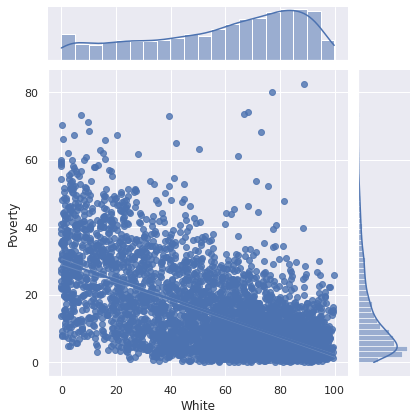

In [ ]:
sns.jointplot(x='White', y='Poverty', data=df, kind="reg")

In [ ]:
arizona = df[df['State']=='Arizona']

In [ ]:
arizona

CensusTract    State County  TotalPop   Men  Women  Hispanic  White  \
0     4007000100  Arizona   Gila      1608   865    743       4.9   93.3   
1     4007000200  Arizona   Gila      2112  1051   1061       7.9   91.8   
2     4007000301  Arizona   Gila      6228  2719   3509      11.7   85.0   
3     4007000302  Arizona   Gila      2746  1298   1448       6.1   91.7   
4     4007000400  Arizona   Gila      3922  1905   2017      10.8   84.4   
..           ...      ...    ...       ...   ...    ...       ...    ...   
966   4021002300  Arizona  Pinal      2897  1582   1315      52.3   44.4   
967   4021002400  Arizona  Pinal      2203  1174   1029      64.5   29.6   
968   4021941200  Arizona  Pinal      6827  3343   3484       7.4    3.0   
969   4021941300  Arizona  Pinal      3158  1553   1605       6.7    3.8   
970   4021941400  Arizona  Pinal      8282  4210   4072      37.1   36.6   

     Black  Native  Asian  Pacific  Citizen   Income  IncomeErr  IncomePerCap  \
0      0.0     1.1    0.7      0.0     1543  52336.0    19663.0       32179.0   
1      0.0     0.0    0.0      0.0     1610  42727.0     9881.0       27730.0   
2      0.1     2.3    0.0      0.0     5117  44781.0     6047.0       22317.0   
3      0.0     0.5    0.0      0.0     2311  40931.0     2759.0       22150.0   
4      1.5     0.5    1.2      0.0     3302  45283.0     4492.0       30122.0   
..     ...     ...    ...      ...      ...      ...        ...           ...   
966    0.9     0.2    1.6      0.0     2135  52596.0    15071.0       20606.0   
967    0.0     0.7    0.0      0.0     1457  36458.0     4970.0       16568.0   
968    0.5    85.3    0.3      0.0     4796  21076.0     9613.0        9936.0   
969    0.0    85.6    3.0      0.1     2280  26042.0    11135.0        9133.0   
970    3.0    19.5    0.9      0.0     5310  30611.0     5039.0       14268.0   

     IncomePerCapErr  Poverty  ChildPoverty  Professional  Service  Office  \
0             5105.0      7.8           0.0          32.3     12.2    45.7   
1             7654.0     18.4          32.8          32.1     22.7    26.5   
2             2457.0     17.5          26.5          37.6     23.0    21.5   
3             2422.0     14.9          15.9          24.7     25.3    32.9   
4             3884.0      9.7           0.0          42.1     20.2    11.5   
..               ...      ...           ...           ...      ...     ...   
966           2686.0     18.6          25.1          18.0     26.0     9.4   
967           2085.0     20.3          28.2          16.6     24.2    19.6   
968           1707.0     53.0          65.5          15.5     39.1    18.9   
969           1646.0     50.6          65.1           8.7     36.3    31.0   
970           2266.0     29.3          33.0          20.4     18.2    13.0   

     Construction  Production  Drive  Carpool  Transit  Walk  OtherTransp  \
0             0.0         9.8   87.0      1.8      0.0   5.9          0.0   
1            13.0         5.7   72.6      3.5      0.0   3.2          3.6   
2             9.3         8.6   84.7      6.8      0.0   0.0          0.0   
3            13.8         3.4   88.1      4.2      0.0   0.0          4.1   
4            18.8         7.5   80.2      7.9      0.0   0.9          0.8   
..            ...         ...    ...      ...      ...   ...          ...   
966          25.3        21.3   80.0      8.3      3.4   1.0          3.1   
967          23.2        16.3   75.0     16.8      2.6   3.1          0.0   
968          13.2        13.4   75.9     15.9      1.3   2.4          2.2   
969          16.5         7.5   77.1     15.1      0.0   1.0          5.2   
970          29.9        18.5   75.7     18.3      0.0   4.3          1.3   

     WorkAtHome  MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
0           5.3         21.6       508         77.6        18.5           3.9   
1          17.1         24.8       714         74.1        19.3           6.6   
2           8.

The EDA shows linear regression has a high predictive value. We need to figure out which variables are statistically significant. 

Load dataset with zip code data and group by county. Then, we willl index the table by the zip code. 

In [ ]:
#Load Tract to Zip Crosswalk
df2 = pd.read_csv('/content/drive/MyDrive/DATA 606 Capstone Project/Datasets and Information/CSVs/TRACT_ZIP_122015.csv')

In [ ]:
df.merge(df2,on='CensusTract')

CensusTract     State              County  TotalPop   Men  Women  \
0      4007000100   Arizona                Gila      1608   865    743   
1      4007000200   Arizona                Gila      2112  1051   1061   
2      4007000301   Arizona                Gila      6228  2719   3509   
3      4007000302   Arizona                Gila      2746  1298   1448   
4      4007000400   Arizona                Gila      3922  1905   2017   
...           ...       ...                 ...       ...   ...    ...   
8851  51685920100  Virginia  Manassas Park city      7069  3831   3238   
8852  51685920100  Virginia  Manassas Park city      7069  3831   3238   
8853  51685920100  Virginia  Manassas Park city      7069  3831   3238   
8854  51685920200  Virginia  Manassas Park city      8556  4388   4168   
8855  51685920200  Virginia  Manassas Park city      8556  4388   4168   

      Hispanic  White  Black  Native  Asian  Pacific  Citizen   Income  \
0          4.9   93.3    0.0     1.1    0.7      0.0     1543  52336.0   
1          7.9   91.8    0.0     0.0    0.0      0.0     1610  42727.0   
2         11.7   85.0    0.1     2.3    0.0      0.0     5117  44781.0   
3          6.1   91.7    0.0     0.5    0.0      0.0     2311  40931.0   
4         10.8   84.4    1.5     0.5    1.2      0.0     3302  45283.0   
...        ...    ...    ...     ...    ...      ...      ...      ...   
8851      49.3   36.2    5.0     0.0    4.8      0.0     3499  68454.0   
8852      49.3   36.2    5.0     0.0    4.8      0.0     3499  68454.0   
8853      49.3   36.2    5.0     0.0    4.8      0.0     3499  68454.0   
8854      23.6   40.5   17.9     0.4   13.4      0.0     4895  80430.0   
8855      23.6   40.5   17.9     0.4   13.4      0.0     4895  80430.0   

      IncomeErr  IncomePerCap  IncomePerCapErr  Poverty  ChildPoverty  \
0       19663.0       32179.0           5105.0      7.8           0.0   
1        9881.0       27730.0           7654.0     18.4          32.8   
2        6047.0       22317.0           2457.0     17.5          26.5   
3        2759.0       22150.0           2422.0     14.9          15.9   
4        4492.0       30122.0           3884.0      9.7           0.0   
...         ...           ...              ...      ...           ...   
8851    10073.0       21151.0           2085.0      7.9           8.5   
8852    10073.0       21151.0           2085.0      7.9           8.5   
8853    10073.0       21151.0           2085.0      7.9           8.5   
8854    14226.0       33959.0           3061.0      8.0          11.6   
8855    14226.0       33959.0           3061.0      8.0          11.6   

      Professional  Service  Office  Construction  Production  Drive  Carpool  \
0             32.3     12.2    45.7           0.0         9.8   87.0      1.8   
1             32.1     22.7    26.5          13.0         5.7   72.6      3.5   
2             37.6     23.0    21.5           9.3         8.6   84.7      6.8   
3             24.7     25.3    32.9          13.8         3.4   88.1      4.2   
4             42.1     20.2    11.5          18.8         7.5   80.2      7.9   
...            ...      ...     ...           ...         ...    ...      ...   
8851          19.9     20.1    21.9          22.1        16.1   68.6     23.4   
8852          19.9     20.1    21.9          22.1        16.1   68.6     23.4   
8853          19.9     20.1    21.9          22.1        16.1   68.6     23.4   
8854          44.1     10.7    29.2           7.3         8.7   73.1     10.1   
8855          44.1     10.7    29.2           7.3         8.7   73.1     10.1   

      Transit  Walk  OtherTransp  WorkAtHome  MeanCommute  Employed  \
0         0.0   5.9          0.0         5.3         21.6       508   
1         0.0   3.2          3.6        17.1         24.8       714   
2         0.0   0.0          0.0         8.5         26.1      1887   
3         0.0   0.0          4.1         3.5         17.3      1148   
4         0.0   0.9    

In [ ]:
df3 = pd.merge(df, df2)

In [ ]:
df3.groupby('County').ZIP.mean().sort_values(ascending = False)

County
Gila                   85500.500000
Pinal                  85191.072464
Maricopa               85186.896026
Mille Lacs             56223.409091
Le Sueur               56054.230769
Sherburne              55483.555556
Hennepin               55403.939394
Carver                 55370.696429
Wright                 55343.596491
Anoka                  55270.839695
Isanti                 55152.666667
Dakota                 55118.408163
Ramsey                 55116.526087
Chisago                55045.081081
Scott                  44848.209677
Douglas                42549.881579
Washington             36632.000000
Pierce                 31529.133333
Jefferson              30662.764706
Fulton                 30284.853365
Clayton                30271.807692
Fayette                30237.410256
DeKalb                 30221.489933
Cherokee               30138.281250
Gwinnett               30111.866953
Cobb                   30106.290698
Rockdale               30066.200000
Clarke               

In [ ]:
ZIP_mean = df3.groupby('County').ZIP.mean().sort_values(ascending = False)

In [ ]:
df3.set_index('ZIP')

CensusTract     State              County  TotalPop   Men  Women  \
ZIP                                                                       
85544   4007000100   Arizona                Gila      1608   865    743   
85541   4007000200   Arizona                Gila      2112  1051   1061   
85541   4007000301   Arizona                Gila      6228  2719   3509   
85541   4007000302   Arizona                Gila      2746  1298   1448   
85541   4007000400   Arizona                Gila      3922  1905   2017   
...            ...       ...                 ...       ...   ...    ...   
20113  51685920100  Virginia  Manassas Park city      7069  3831   3238   
20110  51685920100  Virginia  Manassas Park city      7069  3831   3238   
20111  51685920100  Virginia  Manassas Park city      7069  3831   3238   
20111  51685920200  Virginia  Manassas Park city      8556  4388   4168   
20110  51685920200  Virginia  Manassas Park city      8556  4388   4168   

       Hispanic  White  Black  Native  Asian  Pacific  Citizen   Income  \
ZIP                                                                       
85544       4.9   93.3    0.0     1.1    0.7      0.0     1543  52336.0   
85541       7.9   91.8    0.0     0.0    0.0      0.0     1610  42727.0   
85541      11.7   85.0    0.1     2.3    0.0      0.0     5117  44781.0   
85541       6.1   91.7    0.0     0.5    0.0      0.0     2311  40931.0   
85541      10.8   84.4    1.5     0.5    1.2      0.0     3302  45283.0   
...         ...    ...    ...     ...    ...      ...      ...      ...   
20113      49.3   36.2    5.0     0.0    4.8      0.0     3499  68454.0   
20110      49.3   36.2    5.0     0.0    4.8      0.0     3499  68454.0   
20111      49.3   36.2    5.0     0.0    4.8      0.0     3499  68454.0   
20111      23.6   40.5   17.9     0.4   13.4      0.0     4895  80430.0   
20110      23.6   40.5   17.9     0.4   13.4      0.0     4895  80430.0   

       IncomeErr  IncomePerCap  IncomePerCapErr  Poverty  ChildPoverty  \
ZIP                                                                      
85544    19663.0       32179.0           5105.0      7.8           0.0   
85541     9881.0       27730.0           7654.0     18.4          32.8   
85541     6047.0       22317.0           2457.0     17.5          26.5   
85541     2759.0       22150.0           2422.0     14.9          15.9   
85541     4492.0       30122.0           3884.0      9.7           0.0   
...          ...           ...              ...      ...           ...   
20113    10073.0       21151.0           2085.0      7.9           8.5   
20110    10073.0       21151.0           2085.0      7.9           8.5   
20111    10073.0       21151.0           2085.0      7.9           8.5   
20111    14226.0       33959.0           3061.0      8.0          11.6   
20110    14226.0       33959.0           3061.0      8.0          11.6   

       Professional  Service  Office  Construction  Production  Drive  \
ZIP                                                                     
85544          32.3     12.2    45.7           0.0         9.8   87.0   
85541          32.1     22.7    26.5          13.0         5.7   72.6   
85541          37.6     23.0    21.5           9.3         8.6   84.7   
85541          24.7     25.3    32.9          13.8         3.4   88.1   
85541          42.1     20.2    11.5          18.8         7.5   80.2   
...             ...      ...     ...           ...         ...    ...   
20113          19.9     20.1    21.9          22.1        16.1   68.6   
20110          19.9     20.1    21.9          22.1        16.1   68.6   
20111          19.9     20.1    21.9          22.1        16.1   68.6   
20111          44.1     10.7    29.2           7.3         8.7   73.1   
20110          44.1     10.7    29.2           7.3         8.7   73.1   

       Carpool  Transit  Walk  OtherTransp  WorkAtHome  MeanCommute  Employed  \
ZIP                                                          

In [ ]:
df3.sort_values(by='IncomePerCap', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)

CensusTract        State      County  TotalPop    Men  Women  Hispanic  \
1641   4021002002      Arizona       Pinal      8219   7696    523      49.7   
1640   4021002002      Arizona       Pinal      8219   7696    523      49.7   
2177   9013881200  Connecticut     Tolland     10991   5016   5975       6.3   
2178   9013881200  Connecticut     Tolland     10991   5016   5975       6.3   
1594   4021000803      Arizona       Pinal     11483  10931    552      42.2   
...           ...          ...         ...       ...    ...    ...       ...   
5519  24031706008     Maryland  Montgomery      5070   2458   2612       3.3   
7900  51059480201     Virginia     Fairfax      4500   2181   2319       1.9   
5520  24031706009     Maryland  Montgomery      5359   2724   2635       5.8   
5521  24031706009     Maryland  Montgomery      5359   2724   2635       5.8   
7863  51059470100     Virginia     Fairfax      2913   1471   1442       9.0   

      White  Black  Native  Asian  Pacific  Citizen    Income  IncomeErr  \
1641   22.4   12.3     3.1    4.7      4.5     5975   37639.0    17054.0   
1640   22.4   12.3     3.1    4.7      4.5     5975   37639.0    17054.0   
2177   71.2    5.4     0.0   13.4      0.0    10052   34485.0    14404.0   
2178   71.2    5.4     0.0   13.4      0.0    10052   34485.0    14404.0   
1594   39.6    9.9     5.1    0.5      0.5     9505   47727.0    11892.0   
...     ...    ...     ...    ...      ...      ...       ...        ...   
5519   75.4    0.3     0.0   19.9      0.0     3664  236576.0    39408.0   
7900   73.4    3.6     0.0   15.8      0.6     3181  237269.0    32776.0   
5520   76.8    2.8     0.0   12.4      0.0     3724  245169.0    23674.0   
5521   76.8    2.8     0.0   12.4      0.0     3724  245169.0    23674.0   
7863   72.0    2.5     0.0   13.7      0.0     1941  235114.0    31516.0   

      IncomePerCap  IncomePerCapErr  Poverty  ChildPoverty  Professional  \
1641        3240.0            674.0     42.1          59.4          19.3   
1640        3240.0            674.0     42.1          59.4          19.3   
2177        3987.0            297.0     53.7           0.0          25.7   
2178        3987.0            297.0     53.7           0.0          25.7   
1594        4021.0            691.0     18.6          17.5          29.6   
...            ...              ...      ...           ...           ...   
5519      117075.0          12233.0      0.8           0.7          74.8   
7900      119456.0          16296.0      2.5           0.0          80.2   
5520      128886.0          12764.0      3.0           1.9          80.2   
5521      128886.0          12764.0      3.0           1.9          80.2   
7863      132436.0          22296.0      1.3           0.0          75.7   

      Service  Office  Construction  Production  Drive  Carpool  Transit  \
1641     28.4    30.0           5.3        16.9   73.2     17.0      0.0   
1640     28.4    30.0           5.3        16.9   73.2     17.0      0.0   
2177     35.0    34.4           2.7         2.2   15.3      2.5     11.6   
2178     35.0    34.4           2.7         2.2   15.3      2.5     11.6   
1594     32.1    16.8          19.6         1.8   76.6     12.5      0.0   
...       ...     ...           ...         ...    ...      ...      ...   
5519      8.6    14.8           0.4         1.3   77.1      7.3      0.4   
7900      4.2    13.6           0.4         1.5   78.4      7.3      3.7   
5520      5.2    12.7           0.0         1.7   72.5      6.9      5.3   
5521      5.2    12.7           0.0         1.7   72.5      6.9      5.3   
7863      8.4    14.6           0.0         1.3   71.3      9.5      0.8   

      Walk  OtherTransp  WorkAtHome  MeanCommute  Employed  PrivateWork  \
1641   3.0          3.0         3.8         25.5       243         70.4   
1640   3.0          3.0         3.8         25.5       243         70.4   
2177  66.6          0.6         3.4         14.7      5404         48.1   
2178  

In [ ]:
df3.County.value_counts

<bound method IndexOpsMixin.value_counts of 0                     Gila
1                     Gila
2                     Gila
3                     Gila
4                     Gila
               ...        
8851    Manassas Park city
8852    Manassas Park city
8853    Manassas Park city
8854    Manassas Park city
8855    Manassas Park city
Name: County, Length: 8856, dtype: object>

In [ ]:
def eda_categ_feat_desc_df3(series_categorical):
    """Generate DataFrame with quantity and percentage of categorical series
    @series_categorical = categorical series
    """
    series_name = series_categorical.name
    val_counts = series_categorical.value_counts()
    val_counts.name = 'quantity'
    val_percentage = series_categorical.value_counts(normalize=True)
    val_percentage.name = "percentage"
    val_concat = pd.concat([val_counts, val_percentage], axis = 1)
    val_concat.reset_index(level=0, inplace=True)
    val_concat = val_concat.rename( columns = {'index': series_name} )
    return val_concat

In [ ]:
def eda_horiz_plot(df3, x, y, title, figsize = (20,15), palette="Blues_d", formating="int"):
    """Using Seaborn, plot horizonal Bar with labels
    !!! Is recomend sort_values(by, ascending) before passing dataframe
    !!! pass few values, not much than 20 is recommended
    """
    #ranked = df3.sort_values(by, axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)
    f, ax = plt.subplots(figsize=figsize)
    sns.barplot(x=x, y=y, data=df, palette=palette)
    ax.set_title(title)
    for p in ax.patches:
        width = p.get_width()
        if(formating == "int"):
            text = int(width)
        else:
            text = '{.2f}'.format(width)
        ax.text(width + 1, p.get_y() + p.get_height() / 2, text, ha = 'left', va = 'center')
    plt.show()


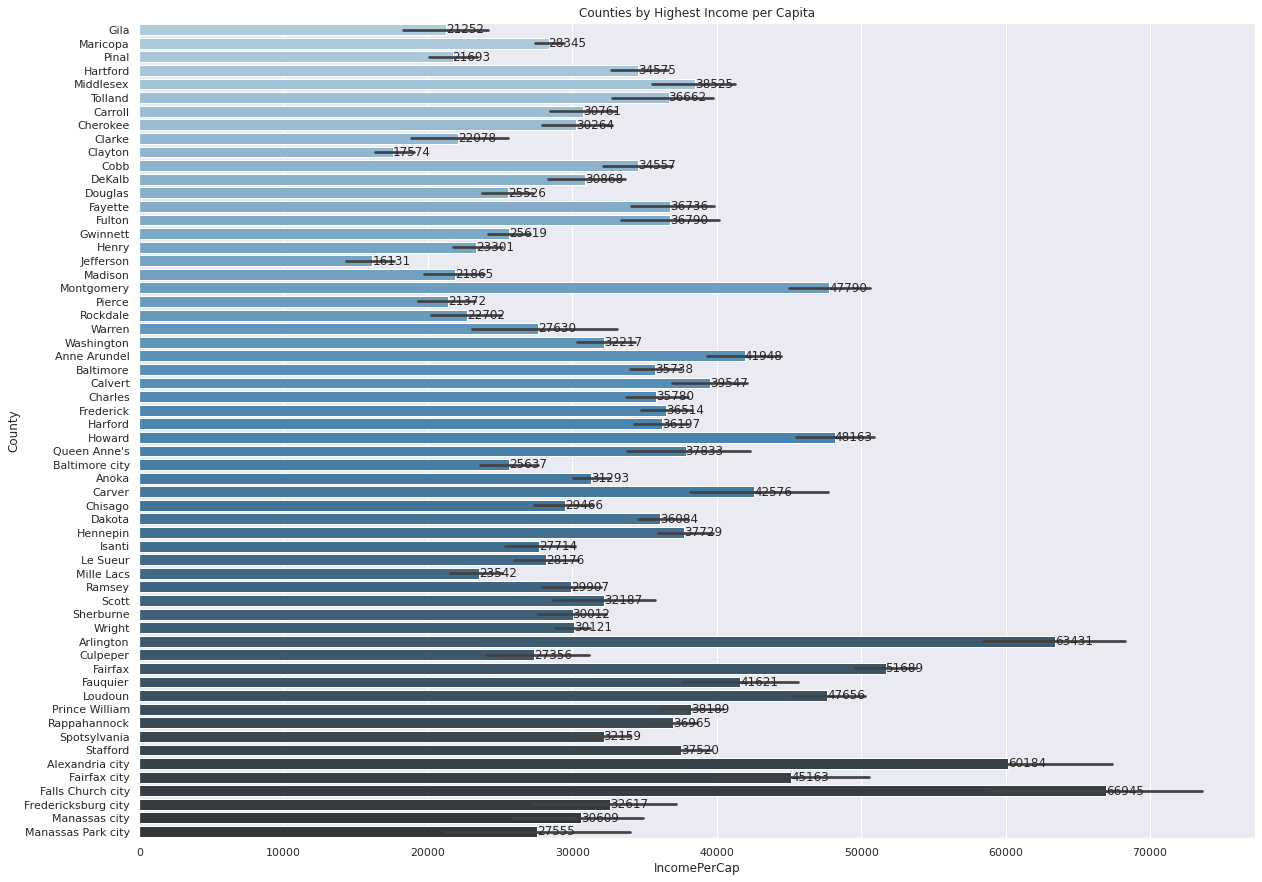

In [ ]:
eda_horiz_plot(eda_categ_feat_desc_df3(df3['County']).head(10),
               'IncomePerCap', 'County', 'Counties by Highest Income per Capita')

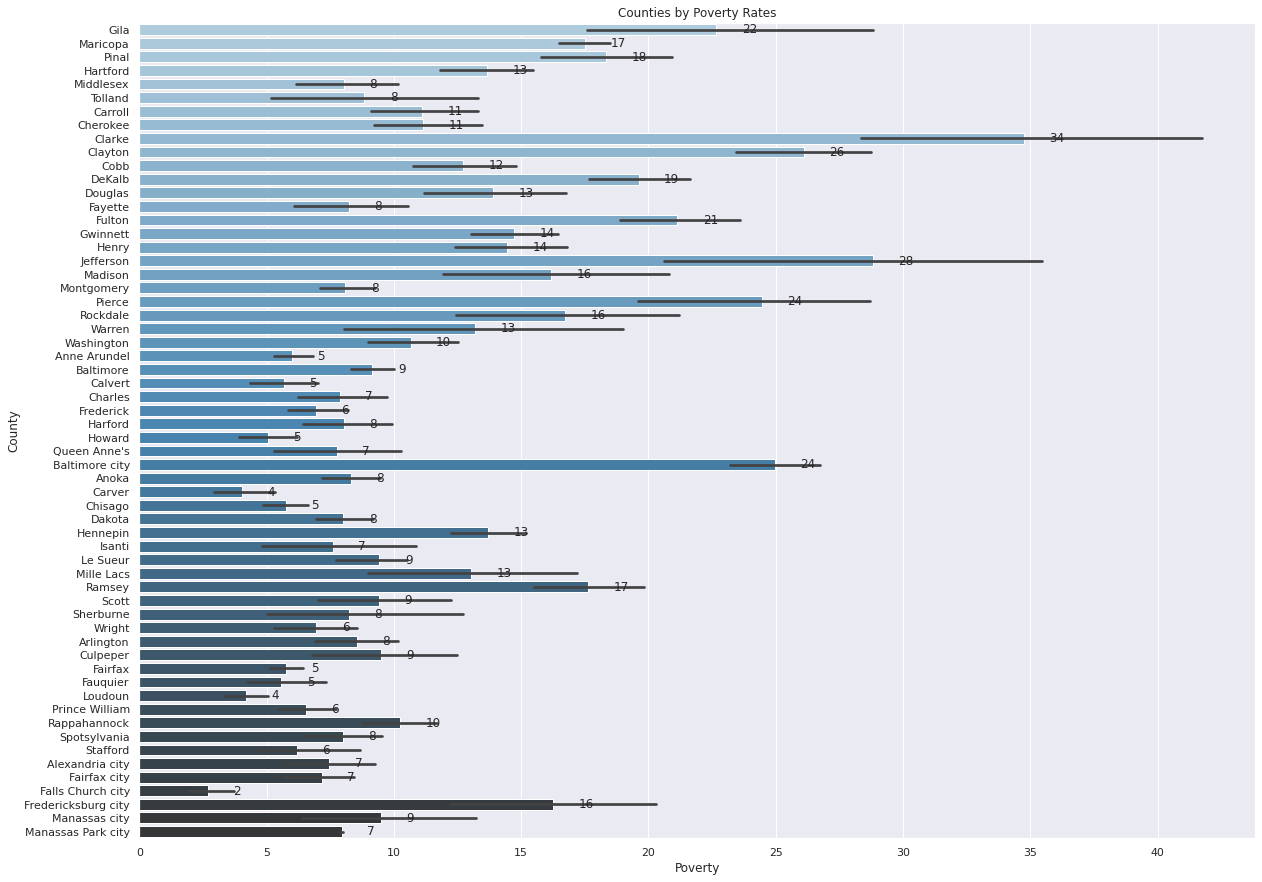

In [ ]:
eda_horiz_plot(eda_categ_feat_desc_df3(df3['County']).head(10),
               'Poverty', 'County', 'Counties by Poverty Rates')

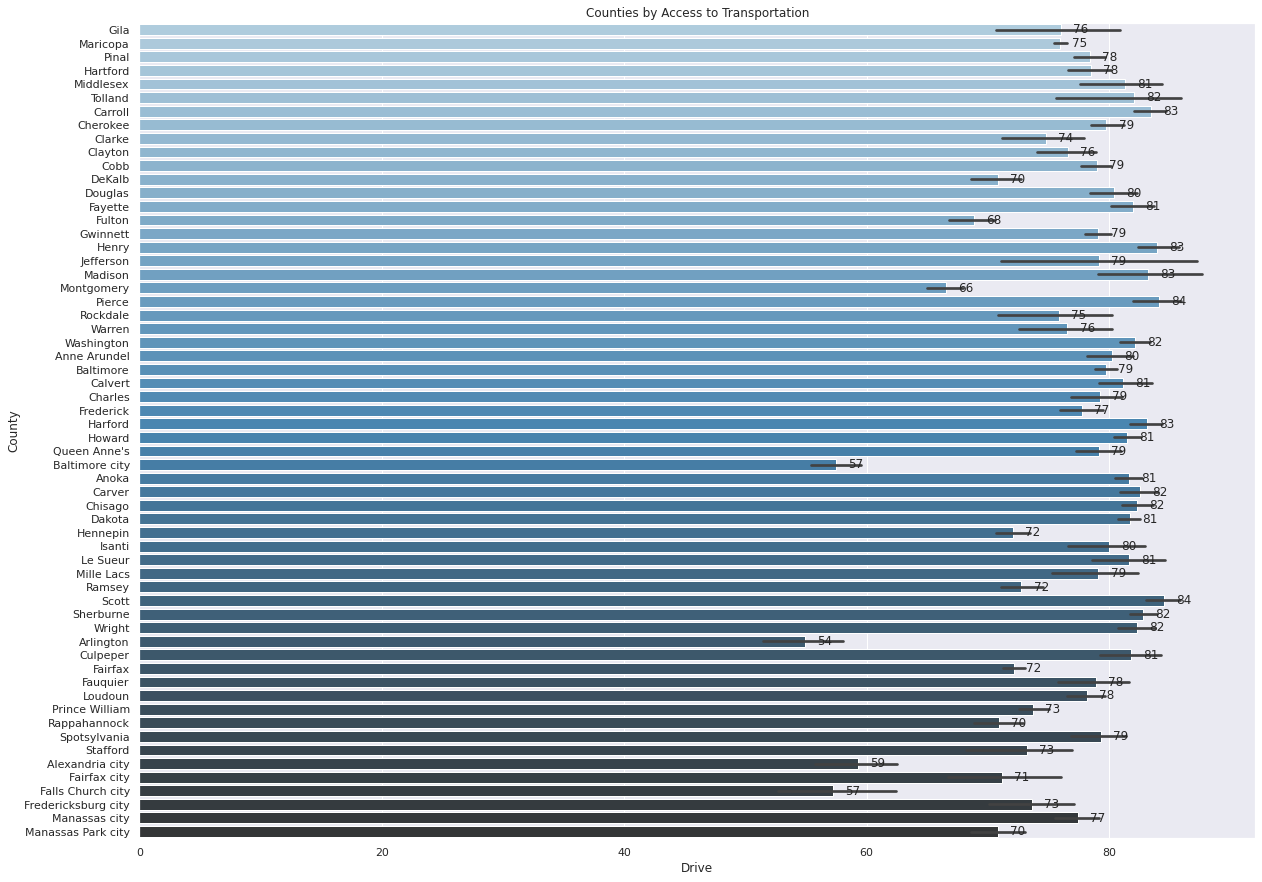

In [ ]:
eda_horiz_plot(eda_categ_feat_desc_df3(df3['County']).head(10),
               'Drive', 'County', 'Counties by Access to Transportation')

In [ ]:
primary_column = 'Income'
target_column = 'ZIP'

df_plot = df3.groupby(['State']).count()[primary_column].reset_index()

Load dataset with census, snap, and zip code data.

In [ ]:
df4 = pd.read_csv('/content/drive/MyDrive/DATA 606 Capstone Project/Datasets and Information/CSVs/Snap2.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (17,18,19,30,31,32,33,34,35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df3.merge(df4,on='ZIP')

CensusTract     State             County_x  TotalPop   Men  Women  \
0        4007000100   Arizona                 Gila      1608   865    743   
1        4007000100   Arizona                 Gila      1608   865    743   
2        4007000100   Arizona                 Gila      1608   865    743   
3        4007000100   Arizona                 Gila      1608   865    743   
4        4007000100   Arizona                 Gila      1608   865    743   
...             ...       ...                  ...       ...   ...    ...   
556778  51510201801  Virginia      Alexandria city      6111  2914   3197   
556779  51510201801  Virginia      Alexandria city      6111  2914   3197   
556780  51510201801  Virginia      Alexandria city      6111  2914   3197   
556781  51610500100  Virginia    Falls Church city      3318  1643   1675   
556782  51630000100  Virginia  Fredericksburg city      3148  1608   1540   

        Hispanic  White  Black  Native  Asian  Pacific  Citizen    Income  \
0            4.9   93.3    0.0     1.1    0.7      0.0     1543   52336.0   
1            4.9   93.3    0.0     1.1    0.7      0.0     1543   52336.0   
2            4.9   93.3    0.0     1.1    0.7      0.0     1543   52336.0   
3            4.9   93.3    0.0     1.1    0.7      0.0     1543   52336.0   
4            4.9   93.3    0.0     1.1    0.7      0.0     1543   52336.0   
...          ...    ...    ...     ...    ...      ...      ...       ...   
556778       9.5   70.2   12.3     0.0    7.0      0.0     5203  121949.0   
556779       9.5   70.2   12.3     0.0    7.0      0.0     5203  121949.0   
556780       9.5   70.2   12.3     0.0    7.0      0.0     5203  121949.0   
556781       3.7   88.6    1.1     0.0    6.0      0.0     2420  137292.0   
556782       2.4   80.6    9.1     0.2    2.0      0.5     2732   61372.0   

        IncomeErr  IncomePerCap  IncomePerCapErr  Poverty  ChildPoverty  \
0         19663.0       32179.0           5105.0      7.8           0.0   
1         19663.0       32179.0           5105.0      7.8           0.0   
2         19663.0       32179.0           5105.0      7.8           0.0   
3         19663.0       32179.0           5105.0      7.8           0.0   
4         19663.0       32179.0           5105.0      7.8           0.0   
...           ...           ...              ...      ...           ...   
556778    12884.0       86002.0           6776.0      5.6           5.5   
556779    12884.0       86002.0           6776.0      5.6           5.5   
556780    12884.0       86002.0           6776.0      5.6           5.5   
556781    22333.0       73624.0          11692.0      1.9           1.8   
556782    12920.0       42962.0           5719.0     10.6           7.9   

        Professional  Service  Office  Construction  Production  Drive  \
0               32.3     12.2    45.7           0.0         9.8   87.0   
1               32.3     12.2    45.7           0.0         9.8   87.0   
2               32.3     12.2    45.7           0.0         9.8   87.0   
3               32.3     12.2    45.7           0.0         9.8   87.0   
4               32.3     12.2    45.7           0.0         9.8   87.0   
...              ...      ...     ...           ...         ...    ...   
556778          78.5      3.4    13.8           1.1         3.2   56.3   
556779          78.5      3.4    13.8           1.1         3.2   56.3   
556780          78.5      3.4    13.8           1.1         3.2   56.3   
556781          75.3      6.2    13.8           3.1         1.7   62.4   
556782          55.3     11.7    24.8           4.6         3.7   68.9   

        Carpool  Transit  Walk  OtherTransp  WorkAtHome  MeanCommute  \
0           1.8      0.0   5.9          0.0         5.3         21.6   
1           1.8      0.0   5.9          0.0         5.3         21.6   
2           1.8      0.0   5.9          0.0         5.3         21.6   
3           1.8      0.0   5.9          0.0         5.3         21.6   
4       

In [ ]:
vars_to_merge = [x for x in df3.columns if x not in ['CountyId', 'state','county']]

In [ ]:
zip_by = pd.DataFrame(df3.groupby(['State', 'County'])['ZIP', 'IncomePerCap','Poverty','Drive','Carpool','Transit','Walk','OtherTransp','Hispanic', 'Black', 'White', 'Asian', 'Native','Pacific'].mean())
zip_by.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


ZIP  IncomePerCap    Poverty      Drive  \
State       County                                                        
Arizona     Gila       85500.500000  21313.136364  21.645455  76.750000   
            Maricopa   85186.896026  29127.445033  17.625828  75.567351   
            Pinal      85191.072464  21760.615942  18.939130  78.818116   
Connecticut Hartford    6099.309824  36226.209068  13.193703  78.074307   
            Middlesex   6434.982456  40664.807018   7.221053  81.315789   
            Tolland     6157.471429  37519.914286   7.705714  82.478571   
Georgia     Carroll    30137.312500  21551.416667  18.933333  81.381250   
            Cherokee   30138.281250  29154.078125  11.556250  79.839062   
            Clarke     30609.964286  19740.196429  38.491071  73.210714   
            Clayton    30271.807692  17424.865385  26.100000  76.186538   

                         Carpool   Transit      Walk  OtherTransp   Hispanic  \
State       County                                                             
Arizona     Gila       10.377273  0.490909  4.259091     2.304545  25.563636   
            Maricopa   10.910199  2.677881  1.914967     2.835298  29.111854   
            Pinal      11.473188  0.332609  1.708696     2.250725  30.232609   
Connecticut Hartford    8.536776  5.152393  3.215869     1.253652  16.868766   
            Middlesex   6.307018  1.938596  4.115789     1.205263   5.301754   
            Tolland     6.761429  1.831429  3.645714     0.630000   3.904286   
Georgia     Carroll    13.177083  0.368750  1.022917     1.358333   5.727083   
            Cherokee    9.514062  0.328125  1.217188     1.550000   9.170312   
            Clarke     10.951786  4.458929  5.441071     3.221429  10.471429   
            Clayton    14.899038  2.500962  1.749038     2.465385  15.025000   

                           Black      White     Asian    Native   Pacific  
State       County                                                         
Arizona     Gila        0.322727  67.500000  0.436364  5.236364  0.072727  
            Maricopa    4.930596  57.980397  3.696954  1.922649  0.187285  
            Pinal       3.489130  57.221739  1.444928  5.798551  0.247101  
Connecticut Hartford   13.685642  61.899748  5.332746  0.104534  0.016121  
            Middlesex   4.536842  85.591228  2.721053  0.061404  0.007018  
            Tolland     1.892857  88.510000  3.582857  0.038571  0.008571  
Georgia     Carroll    14.912500  76.460417  0.608333  0.275000  0.006250  
            Cherokee    6.381250  80.782813  1.378125  0.203125  0.000000  
            Clarke     25.951786  56.589286  4.992857  0.260714  0.016071  
            Clayton    63.516346  13.855769  5.400962  0.170192  0.007692

In [ ]:
zip_by = pd.DataFrame(df3.groupby(['State', 'County'])['Income','Poverty','Hispanic', 'Black', 'White', 'Asian', 'Native','Pacific'].mean())
zip_by.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


Income    Poverty   Hispanic      Black  \
State       County                                                     
Arizona     Gila       38037.318182  21.645455  25.563636   0.322727   
            Maricopa   60421.727152  17.625828  29.111854   4.930596   
            Pinal      48198.985507  18.939130  30.232609   3.489130   
Connecticut Hartford   72199.685139  13.193703  16.868766  13.685642   
            Middlesex  83029.526316   7.221053   5.301754   4.536842   
            Tolland    83244.985714   7.705714   3.904286   1.892857   
Georgia     Carroll    45049.020833  18.933333   5.727083  14.912500   
            Cherokee   66852.671875  11.556250   9.170312   6.381250   
            Clarke     31655.785714  38.491071  10.471429  25.951786   
            Clayton    40285.490385  26.100000  15.025000  63.516346   

                           White     Asian    Native   Pacific  
State       County                                              
Arizona     Gila       67.500000  0.436364  5.236364  0.072727  
            Maricopa   57.980397  3.696954  1.922649  0.187285  
            Pinal      57.221739  1.444928  5.798551  0.247101  
Connecticut Hartford   61.899748  5.332746  0.104534  0.016121  
            Middlesex  85.591228  2.721053  0.061404  0.007018  
            Tolland    88.510000  3.582857  0.038571  0.008571  
Georgia     Carroll    76.460417  0.608333  0.275000  0.006250  
            Cherokee   80.782813  1.378125  0.203125  0.000000  
            Clarke     56.589286  4.992857  0.260714  0.016071  
            Clayton    13.855769  5.400962  0.170192  0.007692

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
census_snap = pd.merge(df3, df4)

In [ ]:
census_snap.set_index('ZIP')

CensusTract     State   County  TotalPop   Men  Women  Hispanic  White  \
ZIP                                                                             
21009  24025301102  Maryland  Harford      3721  1791   1930       5.9   77.4   
21009  24025301102  Maryland  Harford      3721  1791   1930       5.9   77.4   
21009  24025301102  Maryland  Harford      3721  1791   1930       5.9   77.4   
21009  24025301102  Maryland  Harford      3721  1791   1930       5.9   77.4   
21009  24025301102  Maryland  Harford      3721  1791   1930       5.9   77.4   
...            ...       ...      ...       ...   ...    ...       ...    ...   
21160  24025305100  Maryland  Harford      7291  3725   3566       0.2   97.2   
21160  24025305100  Maryland  Harford      7291  3725   3566       0.2   97.2   
21160  24025305100  Maryland  Harford      7291  3725   3566       0.2   97.2   
21005  24025306500  Maryland  Harford      2535  1447   1088       9.0   53.8   
21010  24025306500  Maryland  Harford      2535  1447   1088       9.0   53.8   

       Black  Native  Asian  Pacific  Citizen    Income  IncomeErr  \
ZIP                                                                  
21009    8.7     0.2    5.9      0.0     2792  113958.0    29232.0   
21009    8.7     0.2    5.9      0.0     2792  113958.0    29232.0   
21009    8.7     0.2    5.9      0.0     2792  113958.0    29232.0   
21009    8.7     0.2    5.9      0.0     2792  113958.0    29232.0   
21009    8.7     0.2    5.9      0.0     2792  113958.0    29232.0   
...      ...     ...    ...      ...      ...       ...        ...   
21160    1.6     0.4    0.0      0.0     5779   83036.0    14700.0   
21160    1.6     0.4    0.0      0.0     5779   83036.0    14700.0   
21160    1.6     0.4    0.0      0.0     5779   83036.0    14700.0   
21005   23.5     0.0    5.4      0.2     1727   78616.0     7730.0   
21010   23.5     0.0    5.4      0.2     1727   78616.0     7730.0   

       IncomePerCap  IncomePerCapErr  Poverty  ChildPoverty  Professional  \
ZIP                                                                         
21009       53048.0           8568.0     10.0          14.9          47.4   
21009       53048.0           8568.0     10.0          14.9          47.4   
21009       53048.0           8568.0     10.0          14.9          47.4   
21009       53048.0           8568.0     10.0          14.9          47.4   
21009       53048.0           8568.0     10.0          14.9          47.4   
...             ...              ...      ...           ...           ...   
21160       34092.0           2922.0     10.4          19.8          40.8   
21160       34092.0           2922.0     10.4          19.8          40.8   
21160       34092.0           2922.0     10.4          19.8          40.8   
21005       29717.0           3330.0      6.3           9.4          51.2   
21010       29717.0           3330.0      6.3           9.4          51.2   

       Service  Office  Construction  Production  Drive  Carpool  Transit  \
ZIP                                                                         
21009     14.5    21.8           5.5        10.9   83.3      6.6      0.0   
21009     14.5    21.8           5.5        10.9   83.3      6.6      0.0   
21009     14.5    21.8           5.5        10.9   83.3      6.6      0.0   
21009     14.5    21.8           5.5        10.9   83.3      6.6      0.0   
21009     14.5    21.8           5.5        10.9   83.3      6.6      0.0   
...        ...     ...           ...         ...    ...      ...      ...   
21160     19.2    20.0          13.5         6.5   82.6     10.4      2.1   
21160     19.2    20.0          13.5         6.5   82.6     10.4      2.1   
21160     19.2    20.0          13.5         6.5   82.6     10.4      2.1   
21005     14.6    30.7           2.0         1.4   77.3      4.3      1.6   
21010     14.6    30.7           2.0         1.4   77.3      4.3      1.6   

       Walk  OtherTransp  WorkAtHome  

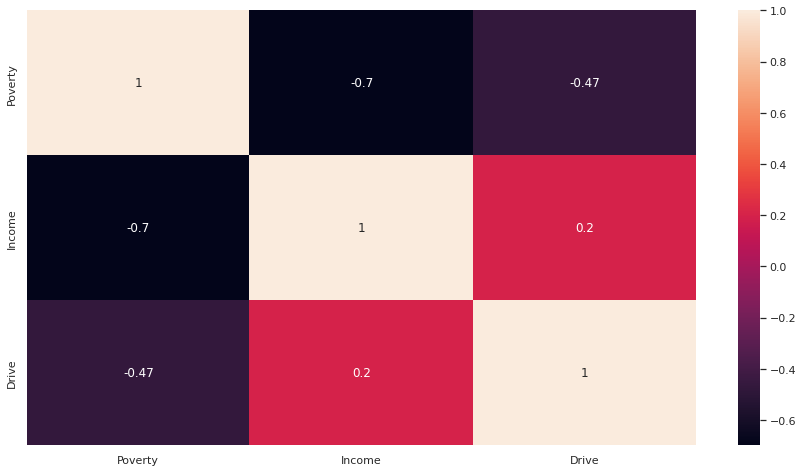

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
f = ( df3.loc[:, ['Poverty','Income', 'Drive']]).corr()
sns.heatmap(f, annot=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

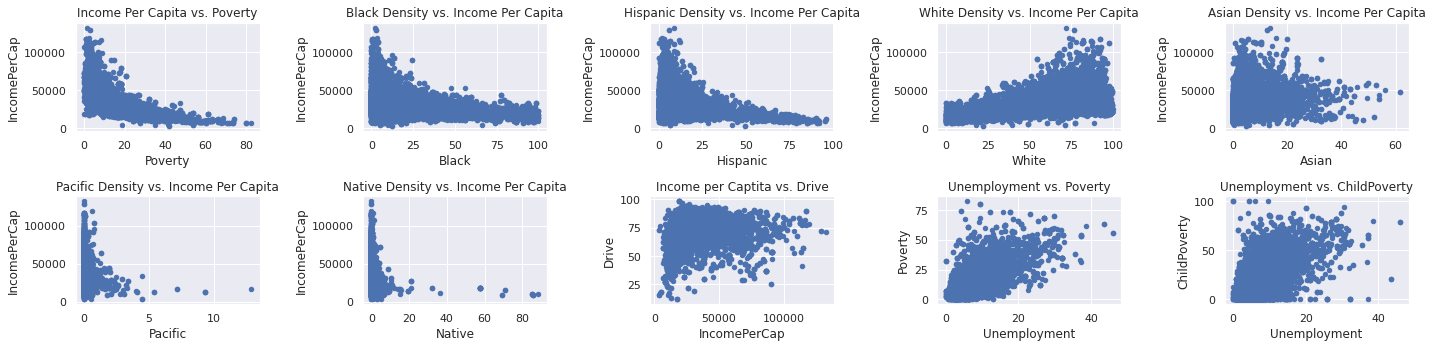

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5)
fig.set_figheight(5)
fig.set_figwidth(20)

df3.plot(ax=axes[0,0],x='Poverty', y='IncomePerCap', kind = 'scatter', title = 'Income Per Capita vs. Poverty')
df3.plot(ax=axes[0,1],x='Black', y='IncomePerCap', kind = 'scatter', title = 'Black Density vs. Income Per Capita')
df3.plot(ax=axes[0,2],x='Hispanic', y='IncomePerCap', kind = 'scatter', title = 'Hispanic Density vs. Income Per Capita')
df3.plot(ax=axes[0,3], x='White', y='IncomePerCap', kind = 'scatter', title = 'White Density vs. Income Per Capita')
df3.plot(ax=axes[0,4], x='Asian', y='IncomePerCap', kind = 'scatter', title = 'Asian Density vs. Income Per Capita')
df3.plot(ax=axes[1,0], x='Pacific', y='IncomePerCap', kind = 'scatter', title = 'Pacific Density vs. Income Per Capita')
df3.plot(ax=axes[1,1], x='Native', y='IncomePerCap', kind = 'scatter', title = 'Native Density vs. Income Per Capita')
df3.plot(ax=axes[1,2], x='IncomePerCap', y='Drive', kind = 'scatter', title = 'Income per Captita vs. Drive')
df3.plot(ax=axes[1,3], x='Unemployment', y='Poverty', kind = 'scatter', title = 'Unemployment vs. Poverty')
df3.plot(ax=axes[1,4], x='Unemployment', y='ChildPoverty', kind = 'scatter', title = 'Unemployment vs. ChildPoverty')

plt.tight_layout()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [ ]:
def plotCorrelationMatrix(df, graphWidth):
    filename = df
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # kdef plotCorrelationMatrix(df, graphWidth):
    filename = df
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # k

In [ ]:
plotCorrelationMatrix(df, 24)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  """


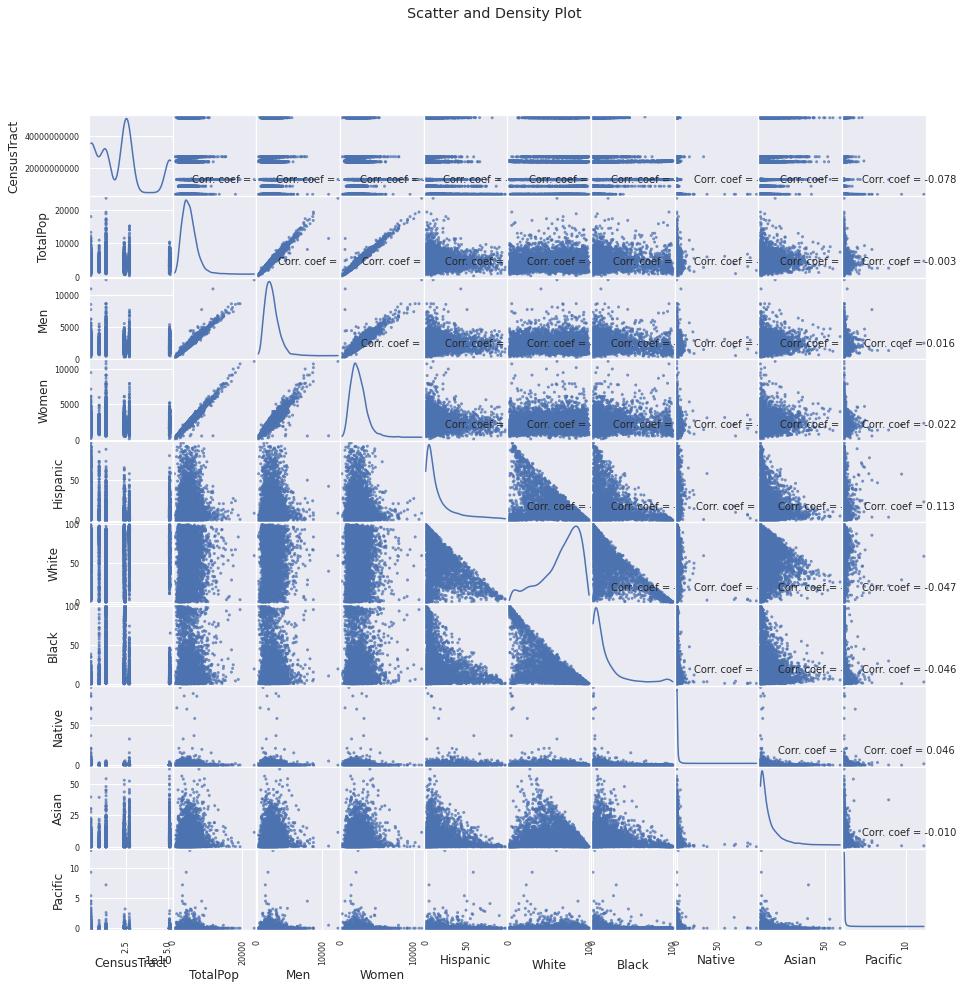

In [ ]:
plotScatterMatrix(df, 15, 10)